# Analyse Rating

Fragen:

- Hat die Transaktionsbewertung Einfluss auf die wirtschaftliche Leistung?

Zusammenfassung Erkenntnisse:
- Die Ratings schwanken über die Zeit, sind in der Mitte der Zeitspanne ganz unten
- Online hat die schlechtesten Ratings -> Ausfälle für verantwortlich? ist in Monat 5 ganz unten
- Tablet Basic hat die schlechtesten Ratings -> geht über die Monate kontinurlich nach unten, hat dann aber einen rasanten Ansteig


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Datenaufbereitung


In [11]:
df_price = (
    pd.read_excel("./../../data/Preise.xlsx")
        .rename(columns={"Jahr": "year",
                         "preis": "price"})
        .assign(year=lambda _data: pd.to_numeric(_data["year"].str.strip('"')))
        .replace([20022, "Tablet Basics"],[2022, "Tablet Basic"])
)

df_dt = (
    pd.read_excel("./../../data/Downtime.xlsx")
        .rename(columns={"Unnamed: 0": "year",
                         "Region A": "a",
                         "Region B": "b",
                         "Region C": "c",
                         "Region D": "d"})
)

df_crm = (
    pd.read_excel("./../../data/CRM_data.xlsx")
        .rename(columns={"id": "transaction_id",
                         "vorname": "firstname",
                         "nachname": "lastname"})
)

def read_regio_data(region, kind): 
    return (pd.read_excel(f"./../../data/Region{region}_{kind}.xlsx")
                .rename(columns={"Tablet Basic": "basic",
                                "Tablet Mini": "mini",
                                "Tablet Pro": "pro",
                                "kosten_mini": "cost_mini",
                                "kosten_basic": "cost_basic",
                                "kosten_pro": "cost_pro",
                                "PRODUKT": "product"})
                .assign(year=lambda _data: _data["date"].dt.year,
                        month=lambda _data: _data["date"].dt.month,
                        week=lambda _data: _data["date"].dt.isocalendar().week,
                        year_month=lambda _data: _data["date"].dt.year.astype(str) + "_" + _data["date"].dt.month.astype(str),
                        cost_basic=lambda _data: np.round(_data["cost_basic"], 2),
                        cost_mini=lambda _data: np.round(_data["cost_mini"], 2),
                        cost_pro=lambda _data: np.round(_data["cost_pro"], 2),
                        cost_per_unit=lambda _data: _data["cost_basic"].fillna(0) + _data["cost_mini"].fillna(0) + _data["cost_pro"].fillna(0),
                        cost=lambda _data: _data["cost_per_unit"] * _data["amount"]
                        )
                .merge(df_price, on=["year", "product"])
                .assign(revenue=lambda _data: _data["price"] * _data["amount"],
                        profit_per_unit=lambda _data: _data["price"] - _data["cost_per_unit"],
                        profit=lambda _data: _data["profit_per_unit"] * _data["amount"])
                .merge(df_crm[["customer_rating", "email", "transaction_id"]], on="transaction_id"))


df_regAo = read_regio_data("A","online")
df_regAp = read_regio_data("A","phone")
df_regAs = read_regio_data("A","store")
df_regBo = read_regio_data("B","online")
df_regBp = read_regio_data("B","phone")
df_regBs = read_regio_data("B","store")
df_regCo = read_regio_data("C","online")
df_regCp = read_regio_data("C","phone")
df_regCs = read_regio_data("C","store")
df_regDo = read_regio_data("D","online")
df_regDp = read_regio_data("D","phone")
df_regDs = read_regio_data("D","store")

# Array mit Zuordnung der DataFrames zu Region und Marketplace
dataframes = [
    (df_regAo, 'A', 'online'),
    (df_regAp, 'A', 'phone'),
    (df_regAs, 'A', 'store'),
    (df_regBo, 'B', 'online'),
    (df_regBp, 'B', 'phone'),
    (df_regBs, 'B', 'store'),
    (df_regCo, 'C', 'online'),
    (df_regCp, 'C', 'phone'),
    (df_regCs, 'C', 'store'),
    (df_regDo, 'D', 'online'),
    (df_regDp, 'D', 'phone'),
    (df_regDs, 'D', 'store')
]

# Spezifisiche Region und Marktplatz zu jedem Frame hinzufügen
for df_reg_main, region, marketplace in dataframes:
    df_reg_main['region'] = region
    df_reg_main['marketplace'] = marketplace

# Alle DataFrames zusammenfügen (concat)
# ignore_index=True: Index wird neu erstellt
df_reg_main = pd.concat([df for df, _, _ in dataframes], ignore_index=True)

In [12]:
df_reg_main.head(100000)

,date,product,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,...,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating,email,region,marketplace
0,2021-11-01,Tablet Basic,1.0,5,1,0,0,170.02,NaN,NaN,...,170.02,850.10,529,2645,358.98,1794.90,7.1,friedhilde.kuhl@yahoo.de,A,online
1,2021-11-01,Tablet Basic,1.0,7,1,0,0,170.02,NaN,NaN,...,170.02,1190.14,529,3703,358.98,2512.86,5.9,heide-marie.fischer@gmx.de,A,online
2,2021-11-01,Tablet Basic,0.9,7,1,0,0,210.03,NaN,NaN,...,210.03,1470.21,529,3703,318.97,2232.79,7.5,ester.pruschke@gmail.com,A,online
3,2021-11-01,Tablet Basic,1.0,10,1,0,0,170.08,NaN,NaN,...,170.08,1700.80,529,5290,358.92,3589.20,6.6,klaus.blümel@aol.de,A,online
4,2021-11-01,Tablet Basic,1.0,4,1,0,0,170.09,NaN,NaN,...,170.09,680.36,529,2116,358.91,1435.64,7.3,waldemar.fritsch@web.de,A,online
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2022-03-08,Tablet Pro,1.0,3,0,0,1,NaN,NaN,800.24,...,800.24,2400.72,999,2997,198.76,596.28,7.6,melitta.geißler@googlemail.com,B,store
99996,2022-03-08,Tablet Pro,1.0,3,0,0,1,NaN,NaN,840.25,...,840.25,2520.75,999,2997,158.75,476.25,7.4,gerhard.stoll@yahoo.de,B,store
99997,2022-03-08,Tablet Pro,1.0,1,0,0,1,NaN,NaN,840.25,...,840.25,840.25,999,999,158.75,158.75,8.2,jasmin.klingelhöfer@web.de,B,store
99998,2022-03-08,Tablet Pro,1.0,1,0,0,1,NaN,NaN,840.25,...,840.25,840.25,999,999,158.75,158.75,8.1,luka.kroker@gmx.de,B,store


In [13]:
df_reg_main.describe()

,date,discount,amount,basic,mini,pro,cost_basic,cost_mini,cost_pro,transaction_id,year,month,week,cost_per_unit,cost,price,revenue,profit_per_unit,profit,customer_rating
count,335253,300164.000000,335253.000000,335253.000000,335253.000000,335253.000000,75253.000000,110000.00000,150000.000000,335253.000000,335253.000000,335253.000000,335253.0,335253.000000,335253.000000,335253.00000,335253.000000,335253.000000,335253.000000,335253.000000
mean,2022-05-13 00:24:06.816583424,0.988871,2.405234,0.224466,0.328110,0.447423,286.214998,211.65353,855.001512,170761.352584,2021.858853,6.574745,26.73928,516.238937,1162.729318,748.38011,1739.700176,232.141173,576.970857,7.587594
min,2021-11-01 00:00:00,0.900000,1.000000,0.000000,0.000000,0.000000,150.000000,136.02000,486.090000,0.000000,2021.000000,1.000000,1.0,136.020000,136.020000,499.00000,499.000000,-186.370000,-2050.070000,1.600000
25%,2022-02-13 00:00:00,1.000000,1.000000,0.000000,0.000000,0.000000,215.000000,171.57000,805.340000,85937.000000,2022.000000,4.000000,14.0,206.730000,447.340000,550.00000,999.000000,133.130000,215.940000,6.700000
50%,2022-05-18 00:00:00,1.000000,2.000000,0.000000,0.000000,0.000000,276.590000,196.21000,859.115000,171144.000000,2022.000000,7.000000,27.0,349.530000,862.610000,680.00000,1497.000000,230.190000,392.620000,7.700000
75%,2022-08-13 00:00:00,1.000000,3.000000,0.000000,1.000000,1.000000,344.040000,259.94000,909.410000,255788.000000,2022.000000,9.000000,39.0,847.510000,1705.780000,999.00000,2116.000000,350.620000,768.750000,8.700000
max,2022-10-31 00:00:00,1.000000,17.000000,1.000000,1.000000,1.000000,685.370000,326.26000,985.000000,339999.000000,2022.000000,12.000000,52.0,985.000000,9557.520000,999.00000,12987.000000,512.910000,7110.600000,10.000000
std,NaN,0.031449,1.579624,0.417231,0.469526,0.497229,86.871362,51.42493,73.858664,98109.396928,0.348174,3.329539,14.505512,314.110280,939.646248,228.49302,1125.267154,120.618094,548.731709,1.580079


Wie ist das durschnittliche Rating jeder Region? -> keine Ausreißer


In [14]:
df_reg_main.groupby("region").agg({"customer_rating": "mean"})


,customer_rating
region,
A,7.553800
B,7.668326
C,7.272400
D,7.801252


Wie ist das durschnittliche Rating jedes Marktplatzes? -> Online ist schlechter als die anderen beiden


In [15]:
df_reg_main.groupby("marketplace").agg({"customer_rating": "mean"})

,customer_rating
marketplace,
online,6.701702
phone,7.869385
store,7.903752


Verändert sich das Rating über die Zeit? -> Rating geht in der Mitte der Zeitspanne deutlich nach unten


c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


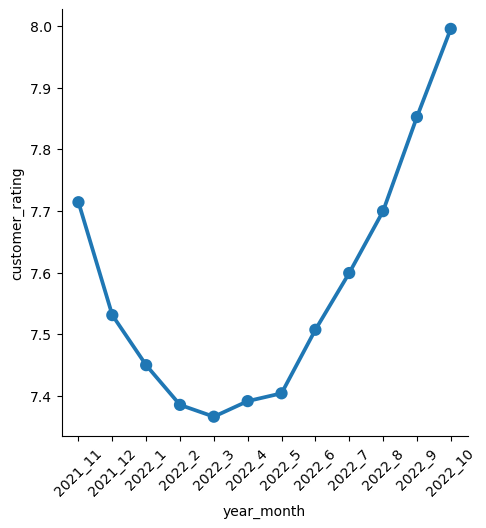

In [51]:
#sns.lineplot(x='date', y='customer_rating', data=df_reg_main)
cat = sns.catplot(data=df_reg_main, x="year_month", y="customer_rating", kind="point", errorbar=None);
cat.set_xticklabels(rotation=45)
plt.show()


Verändert sich das Rating über die Zeit bezogen auf den Marktplatz? -> Es lässt sich erkennen, das das Rating bei allen etwas runter geht, beim Online-Marktplatz aber deutlich stärker (Ausfälle?)

c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


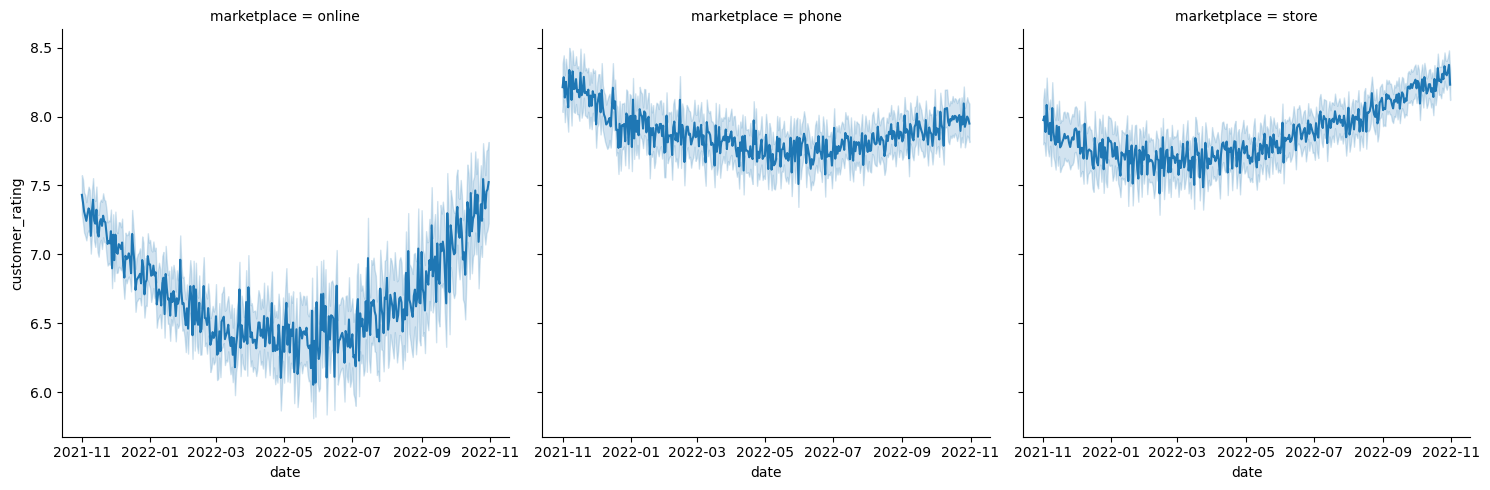

In [17]:
sns.relplot (x='date', y='customer_rating', data=df_reg_main, col='marketplace', kind='line')

Verändert sich das Rating über die Zeit bezogen auf die Region? -> Recht gleich, Region C hat aber die schlechteste Tendenz

c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


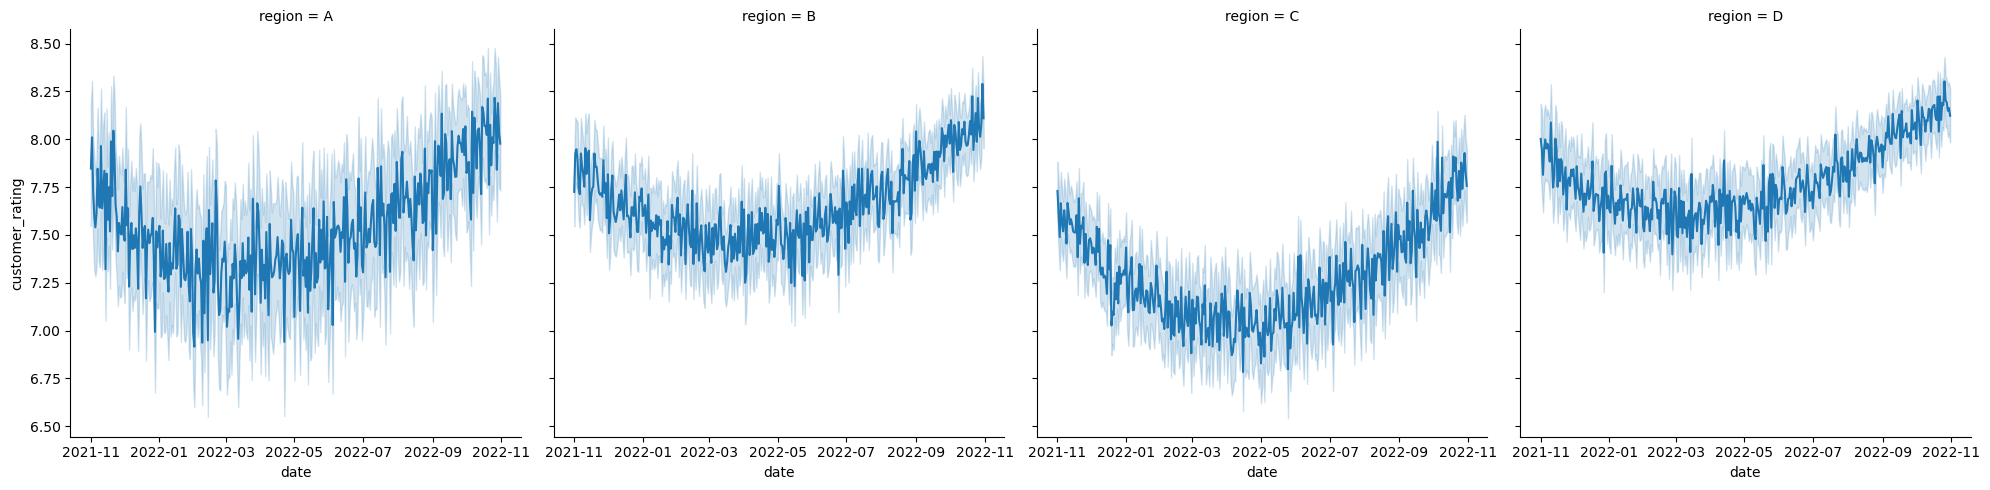

In [18]:
sns.relplot (x='date', y='customer_rating', data=df_reg_main, col='region', kind='line')

Wie verhält sich das Rating bezogen auf die Regionen und den Marktplatz?

- Die Ratings für Phone und Store sind generell höher, haben aber einige Ausreißer nach unten.
- Dadurch, dass die Online-Ratings im Schnitt generell niedriger sind, gibt es bei Online keine Ausreißer.

Erklärung Catplot (Boxplot):

- Die zentrale Linie in jeder Box zeigt den Median der Bewertungen an.
- Die Kanten der Box zeigen das untere (25. Perzentil) und obere (75. Perzentil) Quartil der Daten.
- Die "Whisker" (vertikalen Linien, die aus der Box herausragen) erstrecken sich bis zu den am weitesten entfernten Punkten, die keine Ausreißer sind.
- Punkte, die als Ausreißer gelten (weit entfernt von den Quartilen), werden als individuelle Punkte dargestellt.


c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


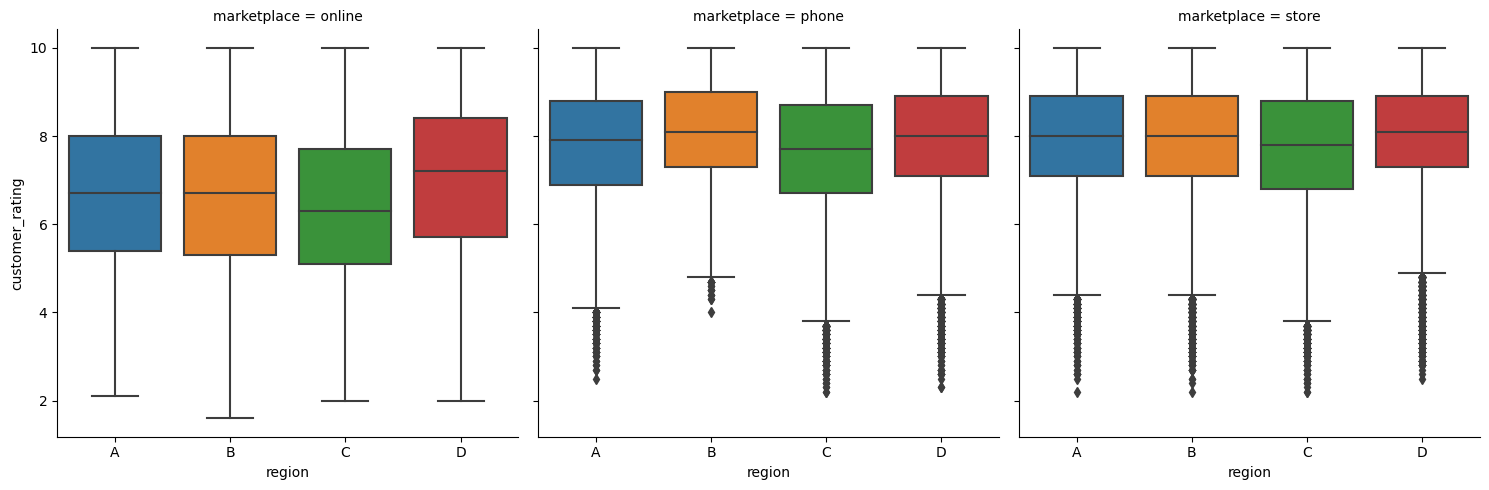

In [19]:
sns.catplot(data=df_reg_main, x="region", y="customer_rating", col="marketplace", 
kind="box")

Wie verhält sich das Rating bei den unterschiedlichen Modellen? -> Tablet Basic ist wohl deutlich unbeliebter

c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


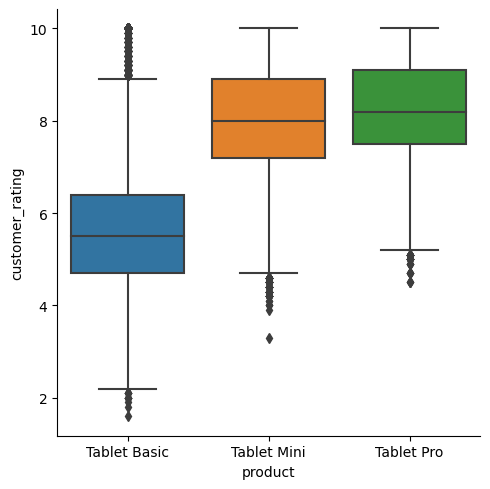

In [20]:
sns.catplot(data=df_reg_main, x="product", y="customer_rating", 
kind="box")

Ist das schlechte Rating von Tablet Basic vom Markplatz abhängig? -> Nicht wirklich

c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


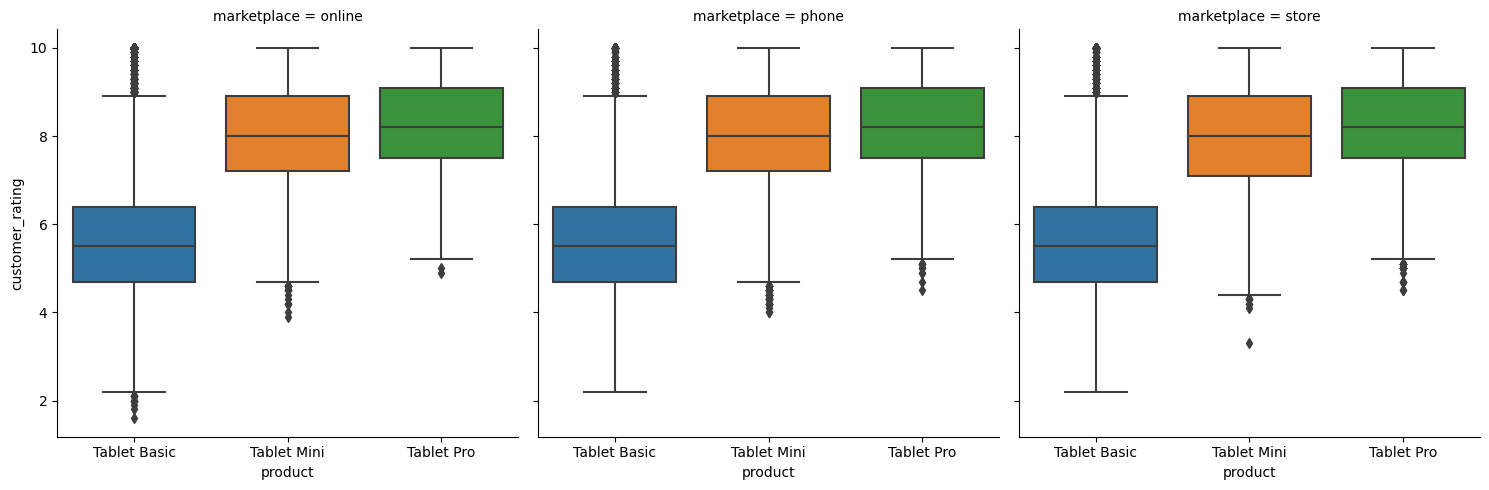

In [21]:
sns.catplot(data=df_reg_main, x="product", y="customer_rating", col="marketplace", 
kind="box")

Ist das schlechte Rating von Tablet Basic von der Region abhängig? -> Nicht wirklich

c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


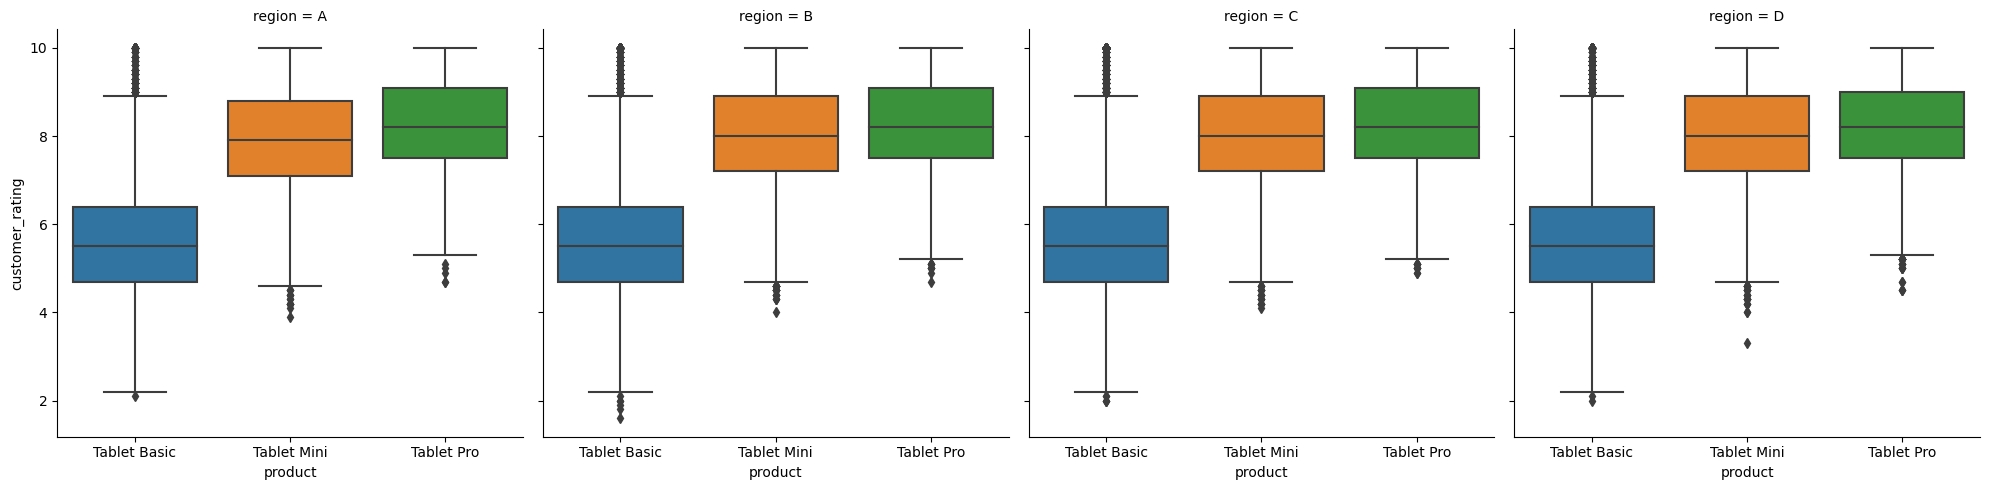

In [22]:
sns.catplot(data=df_reg_main, x="product", y="customer_rating", col="region", 
kind="box")

Wie verhält sich das durschnittliche Rating über die Zeit, gruppiert nach Region? -> Drop in der Mitte, C am schlechtsten


c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


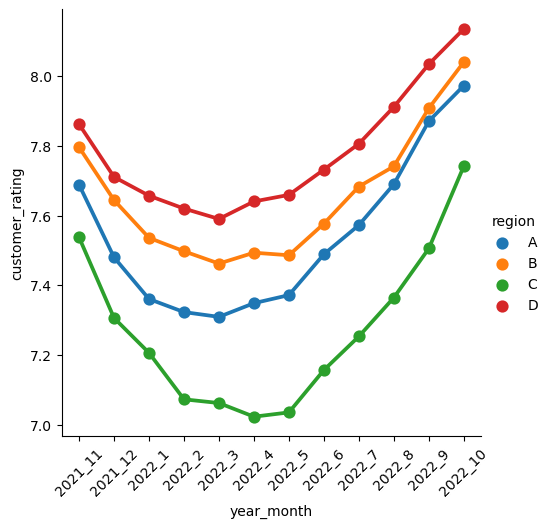

In [44]:
plot = sns.catplot(data=df_reg_main, x="year_month", y="customer_rating", kind="point", hue="region", errorbar=None);
plot.set_xticklabels(rotation=45)
plt.show()

Wie verhält sich das durschnittliche Rating über die Zeit, gruppiert nach Marktplatz? Online droppt in der Mitte und ist tendenziell am schlechtesten

c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


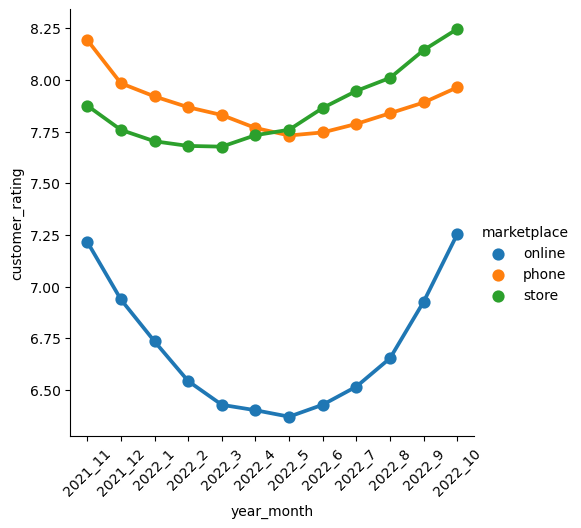

In [46]:
plot = sns.catplot(data=df_reg_main, x="year_month", y="customer_rating", kind="point", hue="marketplace", errorbar=None);
plot.set_xticklabels(rotation=45)
plt.show()

Wie verhält sich das durchschnittliche Rating über die Zeit, gruppiert nach Produkt? Mini Und Basic sinken

c:\Users\timst\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


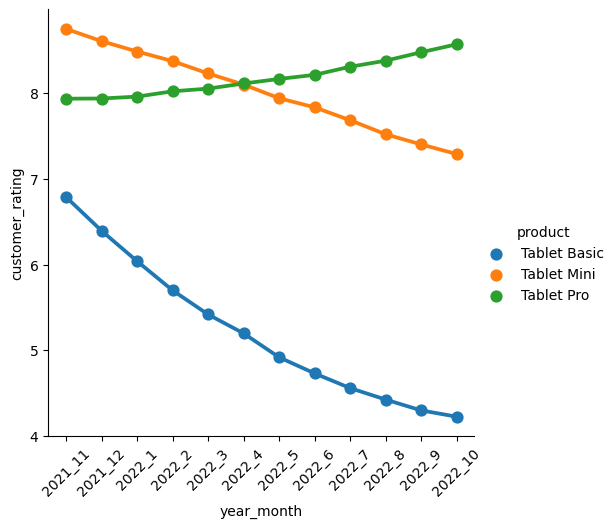

In [41]:
plot = sns.catplot(data=df_reg_main, x="year_month", y="customer_rating", kind="point", hue="product", errorbar=None)
plot.set_xticklabels(rotation=45)
plt.show()


# Sonstiges Zeug...

Wie verläuft der Gewinn pro Monat?

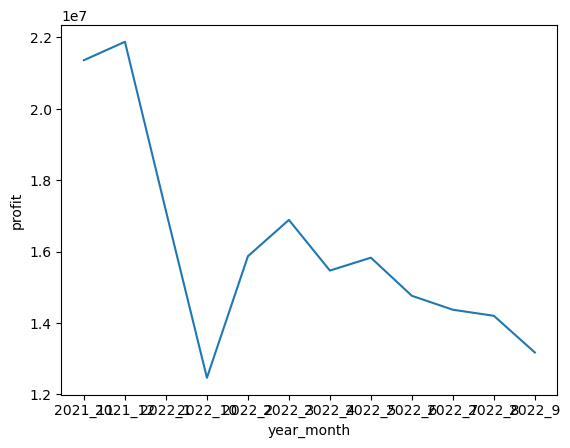

In [50]:
# Aggregieren des Gewinns pro Monat
amount_per_month = df_reg_main.groupby("year_month").agg({"profit": "sum"})

sns.lineplot(data=amount_per_month, x=amount_per_month.index, y="profit");


Wie verläuft der Umsatz pro Monat?


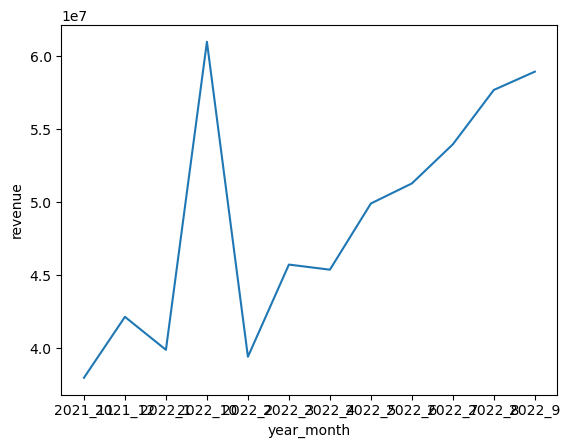

In [27]:
# Aggregieren des Umsatzes pro Monat
amount_per_month = df_reg_main.groupby("year_month").agg({"revenue": "sum"})

sns.lineplot(data=amount_per_month, x=amount_per_month.index, y="revenue");

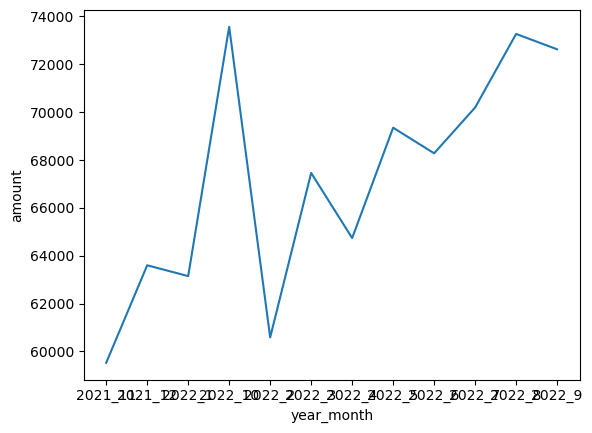

In [28]:
# Aggregieren der verkauften Menge pro Monat
amount_per_month = df_reg_main.groupby("year_month").agg({"amount": "sum"})

sns.lineplot(data=amount_per_month, x=amount_per_month.index, y="amount");

In [29]:
# interessant hier: kunden bestellen auf unterschiedlichen mails

df_reg_main.groupby("email").agg({"customer_rating": "mean"})

,customer_rating
email,
abbas.ackermann@gmail.com,8.40
abbas.ackermann@hotmail.de,10.00
abbas.ackermann@web.de,9.90
abbas.auch_schlauchin@hotmail.de,4.60
abbas.barth@yahoo.de,7.50
...,...
änne.weimer@hotmail.de,5.30
änne.weitzel@aol.de,6.80
änne.weitzel@googlemail.com,3.70


Beziehung zwischen Transaktionsanzahl und Durchschnittsbewertung

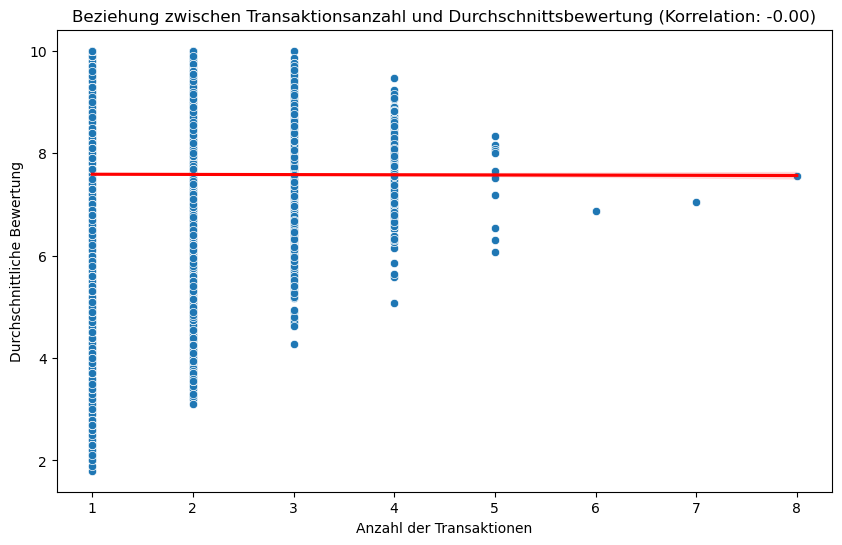

In [30]:
# Aggregieren der Daten
df_aggregated = df_reg_main.groupby('email').agg(
    average_rating=('customer_rating', 'mean'),
    transaction_count=('email', 'count')
).reset_index()

# Korrelationsanalyse
correlation = df_aggregated['average_rating'].corr(df_aggregated['transaction_count'])

# Visualisierung
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_aggregated, x='transaction_count', y='average_rating')

# Regressionslinie hinzufügen
sns.regplot(data=df_aggregated, x='transaction_count', y='average_rating', scatter=False, color='red')

plt.title(f'Beziehung zwischen Transaktionsanzahl und Durchschnittsbewertung (Korrelation: {correlation:.2f})')
plt.xlabel('Anzahl der Transaktionen')
plt.ylabel('Durchschnittliche Bewertung')
plt.show()